# 📘 Knowledge Retrieval & Agentic Chatbot with LangGraph  

This notebook implements a **two-layer architecture** for building intelligent knowledge assistants using **LangGraph + LangChain**:  

---

## 1. 🔎 RAG Pipeline  
- A retrieval-augmented generation (RAG) pipeline.  
- Takes a user query, fetches relevant documents from a vector store, and generates an answer using an LLM.  
- Stateless and one-shot (no memory, no conversation).  
- Supports **file-level filtering** via `selected_files` so users can restrict retrieval to specific uploaded documents.

---

## 2. 🤖 Knowledge Bot (Chatbot)  
- An **agentic AI chatbot** built on top of the `RAGPipeline`.  
- Maintains **conversation state** and **memory** across turns.  
- Uses **tools** (`rag_retrieval`, `calculator`, etc.) to answer user questions.  
- Always tries to search uploaded documents via the RAG pipeline before fallback responses.  
- Respects `selected_files` metadata passed in user queries, allowing focused Q&A on only those chosen documents.  

---

## 🔑 Key Concepts
- **Separation of Concerns**  
  - `RAG Pipeline` = retrieval + generation engine.  
  - `Knowledge Bot` = chat agent with memory, reasoning, and tool use.  

- **File Selection**  
  - The `selected_files` field gives users **fine-grained control** over which documents are searched.  
  - If not provided, the pipeline searches across the full collection.  

- **Extensibility**  
  - Tools can be added (e.g., web search, code execution).  
  - Streaming responses can be enabled for real-time chat experiences.  

- **Use Case**  
  - Ideal for applications where users upload documents and query them interactively.  
  - Example: knowledge assistants, enterprise search, personal document Q&A.  

---


### Set the Thread Id

In [1]:
thread_id = "conv_007"

### File Processing & Chunking

In [2]:
import os
from typing import List, Optional
from fastapi import UploadFile
import fitz
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
import gc


class FileProcessor:
    def __init__(
        self, chunk_size=1000, chunk_overlap=200, max_files=5, max_mb=10
    ) -> None:
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size, chunk_overlap=chunk_overlap, add_start_index=True
        )
        self.max_files = max_files
        self.max_bytes = max_mb * 1024 * 1024  # MB → bytes

    def get_file_name(self, file_path: str) -> str:
        """Generate safe filename (without spaces, lowercase)."""
        base = os.path.basename(file_path)
        name = os.path.splitext(base)[0]
        return name.lower().replace(" ", "_")

    def validate_files(
        self,
        files: Optional[List[UploadFile]] = None,
        file_paths: Optional[List[str]] = None,
    ) -> None:
        """Ensure number and size constraints for both upload files and file paths."""

        if files:
            if len(files) > self.max_files:
                raise ValueError(f"Too many files! Limit = {self.max_files}")

            # For UploadFile objects, check size if available
            for file in files:
                if hasattr(file, "size") and file.size and file.size > self.max_bytes:
                    raise ValueError(
                        f"File {file.filename} exceeds {self.max_bytes/1024/1024:.1f} MB"
                    )

        elif file_paths:
            if len(file_paths) > self.max_files:
                raise ValueError(f"Too many files! Limit = {self.max_files}")

            for fp in file_paths:
                if os.path.getsize(fp) > self.max_bytes:
                    raise ValueError(
                        f"File {fp} exceeds {self.max_bytes/1024/1024:.1f} MB"
                    )

    async def _load_pdf_from_memory(
        self, filename: str, content: bytes
    ) -> List[Document]:
        """Load PDF from memory bytes with proper cleanup."""
        doc = None
        try:
            doc = fitz.open("pdf", content)
            documents = []

            for page_num in range(doc.page_count):
                page = doc[page_num]
                text = page.get_text()

                document = Document(
                    page_content=text,
                    metadata={
                        "source": filename,
                        "page": page_num,
                        "filename": self.get_file_name(filename),
                    },
                )
                documents.append(document)

            return documents

        except Exception as e:
            raise ValueError(f"Error processing PDF {filename}: {str(e)}")
        finally:
            # Close document to free PyMuPDF internal buffers
            if doc is not None:
                doc.close()

    async def load_and_split(
        self,
        files: Optional[List[UploadFile]] = None,
        file_paths: Optional[List[str]] = None,
    ) -> List[Document]:
        """Load and split PDFs with comprehensive memory cleanup."""

        self.validate_files(files=files, file_paths=file_paths)
        all_docs = []

        try:
            if files:
                for file in files:
                    content = None
                    docs = None
                    split_docs = None

                    try:
                        # Read file content
                        content = await file.read()

                        # Validate size
                        if len(content) > self.max_bytes:
                            raise ValueError(
                                f"File {file.filename} exceeds {self.max_bytes/1024/1024:.1f} MB"
                            )

                        # Process PDF (document cleanup handled in _load_pdf_from_memory)
                        docs = await self._load_pdf_from_memory(file.filename, content)

                        # Split documents
                        split_docs = self.text_splitter.split_documents(docs)

                        # Add metadata
                        file_name = self.get_file_name(file.filename)
                        for d in split_docs:
                            d.metadata.update({"filename": file_name})

                        print(f"{file_name}: {len(split_docs)} chunks")
                        all_docs.extend(split_docs)

                        # Reset file pointer
                        await file.seek(0)

                    finally:
                        # Clean up intermediate objects
                        del content, docs, split_docs
                        # Force garbage collection
                        gc.collect()

            elif file_paths:
                for file_path in file_paths:
                    loader = None
                    docs = None
                    split_docs = None

                    try:
                        loader = PyMuPDFLoader(file_path)
                        docs = loader.load()
                        split_docs = self.text_splitter.split_documents(docs)

                        file_name = self.get_file_name(file_path)
                        for d in split_docs:
                            d.metadata.update({"filename": file_name})

                        print(f"{file_name}: {len(split_docs)} chunks")
                        all_docs.extend(split_docs)

                    finally:
                        # Clean up file-based processing
                        del loader, docs, split_docs
                        gc.collect()

            return all_docs

        except Exception as e:
            # Clean up on error
            gc.collect()
            raise e

### Embeddings Manager (Hugging Face)

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings


class EmbeddingsManager:
    def __init__(
        self, model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    ) -> None:
        self._model_name = model_name
        self._embeddings = None  # lazy initialization

    @property
    def embeddings(self) -> HuggingFaceEmbeddings:
        if self._embeddings is None:
            print("Loading embeddings model...")
            self._embeddings = HuggingFaceEmbeddings(model_name=self._model_name)
        return self._embeddings

### Vector Store Management (Qdrant)

In [4]:
from qdrant_client import QdrantClient, models
from qdrant_client.models import Distance, VectorParams, PayloadSchemaType
from langchain_qdrant import QdrantVectorStore


class VectorStoreManager:
    def __init__(self, embeddings: HuggingFaceEmbeddings) -> None:
        self.client = QdrantClient(
            api_key=os.getenv("RAG_CHATBOT_QDRANT_API_KEY"),
            url=os.getenv("RAG_CHATBOT_QDRANT_URL"),
        )
        self.embeddings = embeddings

    def _get_vector_size(self) -> int:
        """Get embedding vector size dynamically."""
        return len(self.embeddings.embed_query("dimension check"))

    def init_collection(self, collection_name: str) -> None:
        """Create collection and indexes if not exists."""
        if not self.client.collection_exists(collection_name):
            vector_size = self._get_vector_size()
            self.client.create_collection(
                collection_name=collection_name,
                vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE),
            )
            print(f"Created collection '{collection_name}'")

            # Create payload index
            self.client.create_payload_index(
                collection_name=collection_name,
                field_name="metadata.filename",
                field_schema=PayloadSchemaType.KEYWORD,
            )
        else:
            print(f"Using existing collection '{collection_name}'")

    def get_vector_store(self, collection_name: str) -> QdrantVectorStore:
        """Return LangChain Qdrant vector store wrapper."""
        return QdrantVectorStore(
            client=self.client,
            collection_name=collection_name,
            embedding=self.embeddings,
        )

    def add_documents(self, collection_name: str, docs: list[Document]) -> None:
        """Insert documents into vector store."""
        vs = self.get_vector_store(collection_name)
        vs.add_documents(docs)
        print(f"Uploaded {len(docs)} chunks to '{collection_name}'")

    def query(
        self,
        collection_name: str,
        query: str,
        selected_files: list[str] | None = None,
        k: int = 3,
    ) -> List[Document]:
        """Search collection with optional filename filter."""
        vs = self.get_vector_store(collection_name)

        filter_ = None
        if selected_files:
            filter_ = models.Filter(
                must=[
                    models.FieldCondition(
                        key="metadata.filename",
                        match=models.MatchAny(any=selected_files),
                    )
                ]
            )

        results = vs.similarity_search(query, k=k, filter=filter_)
        return results

In [5]:
file_processor = FileProcessor()
embeddings_manager = EmbeddingsManager()
vector_store_manager = VectorStoreManager(embeddings=embeddings_manager.embeddings)

Loading embeddings model...


In [6]:
vector_store_manager.init_collection(collection_name=thread_id)

Created collection 'conv_007'


In [7]:
# Multiple files
file_paths = [
    "../docs/Renewable Energy and Sustainability.pdf",
    "../docs/Human Exploration in Space.pdf",
]

In [8]:
# Load & split all files
docs = await file_processor.load_and_split(file_paths=file_paths)

renewable_energy_and_sustainability: 3 chunks
human_exploration_in_space: 4 chunks


In [9]:
# Store all chunks in one collection
vector_store_manager.add_documents(collection_name=thread_id, docs=docs)

Uploaded 7 chunks to 'conv_007'


In [10]:
# Query
query = "who is eligible for leave without pay?"
response = vector_store_manager.query(collection_name=thread_id, query=query)

for doc in response:
    print(f"* {doc.page_content} [{doc.metadata}]")

* progress. 
Q6: What is the long-term vision for humanity in space? 
The long-term vision involves building permanent habitats on the Moon and Mars, developing space-
based solar power stations,  
and creating interplanetary economies. Concepts such as asteroid mining, space tourism, and orbital 
manufacturing may reshape global industries.  
Ultimately, the goal is to ensure humanity’s survival by becoming a spacefaring civilization. [{'producer': 'Microsoft® Word 2021', 'creator': 'Microsoft® Word 2021', 'creationdate': '2025-09-25T10:19:13+05:30', 'source': '../docs/Human Exploration in Space.pdf', 'file_path': '../docs/Human Exploration in Space.pdf', 'total_pages': 1, 'format': 'PDF 1.7', 'title': '', 'author': 'Surya A', 'subject': '', 'keywords': '', 'moddate': '2025-09-25T10:19:13+05:30', 'trapped': '', 'modDate': "D:20250925101913+05'30'", 'creationDate': "D:20250925101913+05'30'", 'page': 0, 'start_index': 2266, 'filename': 'human_exploration_in_space', '_id': '39123cfa-d1ac

### LLM Manager (Model Initialization)

In [11]:
import os
from typing import Optional
from langchain.chat_models import init_chat_model
from langchain_core.language_models import BaseChatModel


class LLMManager:
    """Handles initialization of LLMs with flexibility to switch models or providers."""

    def get_model(
        self,
        model_name: Optional[str] = None,
        model_provider: Optional[str] = None,
    ) -> BaseChatModel:
        """Initialize and return the LLM instance."""

        api_key = os.environ.get("RAG_CHATBOT_LLM_API_KEY")

        if api_key:
            return init_chat_model(
                model=model_name or os.environ["RAG_CHATBOT_LLM_MODEL"],
                model_provider=model_provider or os.environ["RAG_CHATBOT_LLM_PROVIDER"],
                api_key=api_key,
            )
        else:
            return init_chat_model(
                model=model_name or os.environ["RAG_CHATBOT_LLM_MODEL"],
                model_provider=model_provider or os.environ["RAG_CHATBOT_LLM_PROVIDER"],
            )

### RAG Pipeline State Management 

In [12]:
from typing import TypedDict


class RAGPipelineState(TypedDict):
    question: str
    answer: str
    context: List[Document]
    collection_name: str
    selected_files: Optional[list[str]] = None

### RAG Pipeline Models

In [13]:
from typing import Optional
from pydantic import BaseModel


class RAGQueryMetadata(BaseModel):
    selected_files: Optional[list[str]] = None


class RAGQueryRequest(BaseModel):
    user_query: str
    collection_name: str
    metadata: Optional[RAGQueryMetadata] = None


class RAGQueryResponse(BaseModel):
    answer: str
    context: Optional[List[Document]] = None

### RAG Pipeline Workflow Graph (LangGraph)

In [14]:
from typing import Any, Dict
from langgraph.graph import START, END, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph.state import CompiledStateGraph
from IPython.display import Image, display


class RAGPipeline:
    def __init__(
        self, llm_manager: LLMManager, vector_store_manager: VectorStoreManager
    ) -> None:
        self.llm_manager = llm_manager
        self.vector_store_manager = vector_store_manager
        self.compiled_graph: CompiledStateGraph = self._build_rag_graph()

    def _retrieve_documents(self, state: RAGPipelineState) -> Dict[str, Any]:
        retrieved_docs = self.vector_store_manager.query(
            collection_name=state["collection_name"],
            query=state["question"],
            selected_files=state["selected_files"],
        )
        return {"context": retrieved_docs}

    def _generate_answer(self, state: RAGPipelineState):
        llm = self.llm_manager.get_model()
        prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    """You are a helpful assistant. 
                    Use the following pieces of context to answer the question at the end. 
                    If you don't know the answer, just say that you don't know, don't try to make up an answer.
                    {context}
                    """,
                ),
                ("user", "\nQuestion: {question}"),
            ]
        )

        context_texts = [doc.page_content for doc in state["context"]]
        context_combined = "\n\n".join(context_texts)

        chat_input = prompt.format_prompt(
            context=context_combined,
            question=state["question"],
        ).to_messages()

        answer = llm.invoke(chat_input).content
        return {"answer": answer}

    def _build_rag_graph(self) -> CompiledStateGraph:
        graph = StateGraph(RAGPipelineState)

        graph.add_node("retrieve_documents", self._retrieve_documents)
        graph.add_node("generate_answer", self._generate_answer)

        graph.add_edge(START, "retrieve_documents")
        graph.add_edge("retrieve_documents", "generate_answer")
        graph.add_edge("generate_answer", END)

        compiled_graph = graph.compile()
        return compiled_graph

    def display_graph(self) -> None:
        display(Image(self.compiled_graph.get_graph().draw_mermaid_png()))

    def run_pipeline(self, rag_query_request: RAGQueryRequest) -> RAGQueryResponse:
        result = self.compiled_graph.invoke(
            {
                "question": rag_query_request.user_query,
                "collection_name": rag_query_request.collection_name,
                "selected_files": rag_query_request.metadata.selected_files,
            }
        )
        return RAGQueryResponse(answer=result["answer"], context=result.get("context"))

In [15]:
llm_manager = LLMManager()
rag_pipeline = RAGPipeline(
    llm_manager=llm_manager, vector_store_manager=vector_store_manager
)

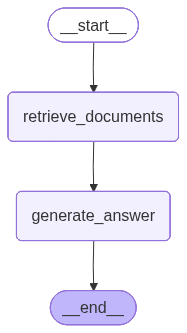

In [16]:
rag_pipeline.display_graph()

In [17]:
user_query = "countries leading in human space exploration"
selected_files = [
    "human_exploration_in_space",
    "renewable_energy_and_sustainability",
]
rag_query_request = RAGQueryRequest(
    user_query=user_query,
    collection_name=thread_id,
    metadata=RAGQueryMetadata(selected_files=selected_files),
)
response = rag_pipeline.run_pipeline(rag_query_request=rag_query_request)
print(f"Rag Bot answer - {response.answer}")
print(response.model_dump_json(indent=4))

Rag Bot answer - According to the context, the countries leading in human space exploration are:

1. The United States (NASA)
2. Russia (Roscosmos)
3. China (CNSA)

These three countries are mentioned as leaders in human space exploration, with the European Space Agency (ESA) also playing a key role as a partner.
{
    "answer": "According to the context, the countries leading in human space exploration are:\n\n1. The United States (NASA)\n2. Russia (Roscosmos)\n3. China (CNSA)\n\nThese three countries are mentioned as leaders in human space exploration, with the European Space Agency (ESA) also playing a key role as a partner.",
    "context": [
        {
            "id": null,
            "metadata": {
                "producer": "Microsoft® Word 2021",
                "creator": "Microsoft® Word 2021",
                "creationdate": "2025-09-25T10:19:13+05:30",
                "source": "../docs/Human Exploration in Space.pdf",
                "file_path": "../docs/Human Explorati

### Knowledge Bot Models

In [18]:
from langgraph.graph import MessagesState


class KnowledgeBotMetadata(BaseModel):
    selected_files: Optional[list[str]] = None


class KnowledgeBotRequest(BaseModel):
    user_query: str
    thread_id: str
    metadata: Optional[KnowledgeBotMetadata] = None

### Knowledge Bot State Management

In [19]:
class KnowledgeBotState(MessagesState):
    selected_files: Optional[list[str]] = None

### Create Tools for Knowledge Bot

In [20]:
from typing import Annotated
from langchain_core.tools import tool
from langgraph.types import Command
from langchain_core.messages import ToolMessage, HumanMessage, SystemMessage
from langgraph.prebuilt import InjectedState
from langchain_core.tools import InjectedToolCallId
from langchain_core.runnables import RunnableConfig


class KnowledgeTools:
    rag_pipeline: RAGPipeline = None

    @classmethod
    def set_rag_pipeline(cls, rag_pipeline):
        cls.rag_pipeline = rag_pipeline

    @tool()
    def calculator(
        a: int,
        b: int,
        tool_call_id: Annotated[str, InjectedToolCallId] = None,
    ) -> Command:
        """
        Use this tool to add two numbers.
        """
        result = a + b
        return Command(
            update={
                "messages": [
                    ToolMessage(
                        content=result,
                        tool_call_id=tool_call_id,
                    )
                ]
            },
        )

    @tool()
    def rag_retrival(
        user_query: str,
        tool_call_id: Annotated[str, InjectedToolCallId] = None,
        state: Annotated[dict, InjectedState] = None,
        special_config_param: RunnableConfig = None,
    ) -> Command:
        """
        Use this tool to search and give details about the documents uploaded by the user.
        """
        thread_id = special_config_param["configurable"]["thread_id"]
        rag_bot_request = RAGQueryRequest(
            user_query=user_query,
            collection_name=thread_id,
            metadata=RAGQueryMetadata(selected_files=state["selected_files"]),
        )
        result = KnowledgeTools.rag_pipeline.run_pipeline(rag_bot_request)
        return Command(
            update={
                "messages": [
                    ToolMessage(
                        content=result,
                        tool_call_id=tool_call_id,
                    )
                ]
            },
        )

In [21]:
KnowledgeTools.set_rag_pipeline(rag_pipeline)

### Knowledge Bot Graph (LangGraph)

In [22]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_core.prompts import MessagesPlaceholder
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig


memory_saver = MemorySaver()


class KnowledgeBotApp:
    def __init__(self, llm_manager: LLMManager) -> None:
        self.llm_manager = llm_manager
        self.knowledge_tools: KnowledgeTools = KnowledgeTools()
        self.compiled_graph: CompiledStateGraph = self._build_rag_graph()

    def _agent(self, state: KnowledgeBotState):
        llm = self.llm_manager.get_model()
        agent_prompt = ChatPromptTemplate(
            [
                SystemMessage(
                    content="""
                    You are a Knowledge Bot that helps users find information from their uploaded documents.
                    IMPORTANT: Always try to search the document collection first using the rag_retrival tool when users ask questions. Only ask them to upload documents if the RAG search returns no results or if there are clearly no documents in the system.
                    Don't ask users to upload documents unless you've first attempted to search the existing document collection.
                    """
                ),
                MessagesPlaceholder(variable_name="messages"),
            ]
        )
        agent_runnable = agent_prompt | llm.bind_tools(
            tools=[self.knowledge_tools.calculator, self.knowledge_tools.rag_retrival]
        )
        response = agent_runnable.invoke(input=state)
        state["messages"] = add_messages(left=state["messages"], right=response)
        return state

    def _build_rag_graph(self) -> CompiledStateGraph:
        graph = StateGraph(KnowledgeBotState)

        graph.add_node("agent", self._agent)
        graph.add_node(
            "tools",
            ToolNode(
                [self.knowledge_tools.calculator, self.knowledge_tools.rag_retrival]
            ),
        )

        graph.set_entry_point("agent")
        graph.add_conditional_edges(
            "agent",
            tools_condition,
            {END: END, "tools": "tools"},
        )
        graph.add_edge("tools", "agent")

        compiled_graph = graph.compile(checkpointer=memory_saver)
        return compiled_graph

    def display_graph(self) -> None:
        display(
            Image(
                self.compiled_graph.get_graph(xray=True).draw_mermaid_png(max_retries=5)
            )
        )

    def run_agent(self, knowledge_bot_request: KnowledgeBotRequest) -> None:
        config = RunnableConfig(
            configurable={"thread_id": knowledge_bot_request.thread_id}
        )
        # response = self.compiled_graph.invoke(
        #     {
        #         "messages": HumanMessage(content=knowledge_bot_request.user_query),
        #         "selected_files": knowledge_bot_request.metadata.selected_files,
        #     },
        #     config=config
        # )
        # print(response["messages"][-1].content)
        # response.pretty_print()

        for step in self.compiled_graph.stream(
            {
                "messages": HumanMessage(content=knowledge_bot_request.user_query),
                "selected_files": knowledge_bot_request.metadata.selected_files,
            },
            config=config,
            stream_mode="values",
        ):
            step["messages"][-1].pretty_print()

In [23]:
knowledge_bot_app = KnowledgeBotApp(llm_manager=llm_manager)

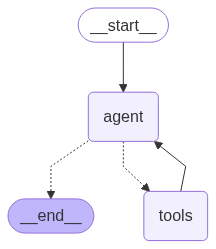

In [24]:
knowledge_bot_app.display_graph()

In [25]:
user_query = "How many countries leading in human space exploration?"


selected_files = [
    "human_exploration_in_space",
    "renewable_energy_and_sustainability",
]

knowledge_bot_request = KnowledgeBotRequest(
    user_query=user_query,
    thread_id=thread_id,
    metadata=KnowledgeBotMetadata(selected_files=selected_files),
)

knowledge_bot_app.run_agent(knowledge_bot_request=knowledge_bot_request)

================================ Human Message =================================

How many countries leading in human space exploration?
================================== Ai Message ==================================
Tool Calls:
  rag_retrival (56801927-43fb-4513-94ad-62e798e0c7a3)
 Call ID: 56801927-43fb-4513-94ad-62e798e0c7a3
  Args:
    user_query: countries leading in human space exploration
================================= Tool Message =================================
Name: rag_retrival

answer='According to Q3 of the provided context, the countries leading in human space exploration today are:\n\n1. The United States (NASA)\n2. Russia (Roscosmos)\n3. China (CNSA)\n\nAdditionally, other countries mentioned as having significant involvement or contributions to human space exploration include:\n\n* India (ISRO) - expanding its presence with human spaceflight plans\n* Japan (JAXA) - contributing advanced robotics\n* European Space Agency (ESA) - a key partner\n\nPrivate companies 

In [26]:
from langgraph.types import StateSnapshot


config = {"configurable": {"thread_id": thread_id}}

snapshot = knowledge_bot_app.compiled_graph.get_state(config)
# print(snapshot)
# _printed = set()


def _print_event(event: StateSnapshot):
    messages = event.values.get("messages", None)
    if messages:
        if not isinstance(messages, list):
            messages = [messages]

        for message in messages:
            message.pretty_print()
            print("\n")


_print_event(snapshot)

================================ Human Message =================================

How many countries leading in human space exploration?


================================== Ai Message ==================================
Tool Calls:
  rag_retrival (56801927-43fb-4513-94ad-62e798e0c7a3)
 Call ID: 56801927-43fb-4513-94ad-62e798e0c7a3
  Args:
    user_query: countries leading in human space exploration


================================= Tool Message =================================
Name: rag_retrival

answer='According to Q3 of the provided context, the countries leading in human space exploration today are:\n\n1. The United States (NASA)\n2. Russia (Roscosmos)\n3. China (CNSA)\n\nAdditionally, other countries mentioned as having significant involvement or contributions to human space exploration include:\n\n* India (ISRO) - expanding its presence with human spaceflight plans\n* Japan (JAXA) - contributing advanced robotics\n* European Space Agency (ESA) - a key partner\n\nPrivate compan